# Author disambiguation for WoS Data

## The problem:

## The solution:

Finding pairs of names that are pretty much similar. Different approaches exists. Manual checking is possible for small data sets. Automatic checking using the followng algorithms:

- Fuzzy matching: Matching words that pretty much are spelled the same. This is used as a baseline. Important here is to set hte threshold for the matching not too high to miss out on homonymes and synonyms, but also not too low to have to many false positives in it.
- Clustering methods:
- Co-authorship network clustering

## Previous work

jdkram author disambiguation git repo: fuzzy matching

inspirehep beard package --> supervised learning

clustering code (cosine, distnace): https://github.com/mozerfazer/AuthorNameDisambiguation/blob/master/wosand/main.py

## Fuzzy matching

Code taken from (jdkram)[www.github.com/jdkram/author_disambiguation]

### Import and configs

In [2]:
import os
import openpyxl
import functools
import matplotlib
import math
import operator as op
import pandas as pd

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
%matplotlib inline

In [4]:
from pathlib import Path
DATA_DIR = Path("C:/Users/0122564s/OneDrive - National University of Ireland, Galway/SFI_project/bibliometric/analysis/biblio_tm")

### Functions 

In [5]:
def load_pubs(csv, pmid_column='PMID', author_column='Authors', encoding='latin1'):
    """Takes input CSV plus options, returns a pandas Series of PMIDs linked to lists of authors"""
    sample_pubs = pd.read_csv(file_path, encoding='latin1')
    author_lists = sample_pubs['AU']
    author_lists = author_lists.str.split(";")
    return(author_lists)

In [6]:
def extract_authors(author_lists, method="all"):
    names = set()
    for auth_list in author_lists:
        if method == "all":
            auth_list = auth_list
        elif method =="ends":
            auth_list = [auth_list[0], auth_list[-1]]
        elif method =="first":
            auth_list = [auth_list[0]]
        elif method =="last":
            auth_list = [auth_list[-1]]
        
        for auth in auth_list:
            if len(auth) > 2:
                names.add(auth)
    return(names)

In [7]:
def generate_pairs(names):
    names_list = names.copy()
    pair_list = []
    while len(names_list) > 1:
        current_name = names_list.pop()
        for name in names_list:
            pair_list.append((current_name, name))
    return(pair_list)

In [8]:
def fuzzy_match(pairs, threshold=80):
    """takes pairs of names, returns a dataframe of pairs with fuzzy scores"""
    pair_scores = [[pair[0], pair[1], fuzz.ratio(pair[0], pair[1])] for pair in pairs]
    df = pd.DataFrame(pair_scores, columns=['name1', 'name2', 'score'])
    df['above_threshold'] = (df['score'] >= threshold)
    return df

### Create author pair list

In [9]:
file_path = os.path.join(DATA_DIR, 'authors.csv')
sample_author_lists = load_pubs(os.path.join(DATA_DIR, 'authors.csv'))

In [10]:
all_names = extract_authors(sample_author_lists, method="all")
list(all_names)[0:10] # preview them

['COCCHIARELLA C',
 'JIMENEZ L',
 'PEREZ L',
 'BRODSKY W',
 'KIRILLOV A',
 'TZENG G',
 'FERNANDEZ-PEREZ V',
 'SABLOK G',
 'TONG S',
 'HARLAN-SIMMONS J']

In [11]:
first_authors = extract_authors(sample_author_lists, method="first")

In [12]:
list(first_authors)[0:10]

['STUETZER M',
 'LAMBERT P',
 'JIMENEZ L',
 'NGOZWANA K',
 'OSMAN I',
 'CLAWSON J',
 'KIM S',
 'PEREZ L',
 'FABBRI F',
 'BRODSKY W']

In [13]:
sample_pairs = generate_pairs(first_authors)

In [14]:
sample_pairs[0:5]

[('STUETZER M', 'LAMBERT P'),
 ('STUETZER M', 'JIMENEZ L'),
 ('STUETZER M', 'NGOZWANA K'),
 ('STUETZER M', 'OSMAN I'),
 ('STUETZER M', 'CLAWSON J')]

### Fuzzy matching

In [15]:
len(sample_pairs)

3265290

In [16]:
sample_scores = fuzzy_match(sample_pairs)

In [17]:
sample_scores.query("above_threshold")

,name1,name2,score,above_threshold
3989,LAMBERT P,LAMB P,80,True
6749,JIMENEZ L,JIMENEZ J,89,True
11599,OSMAN I,OSMAN W,86,True
15293,CLAWSON J,CARSON J,82,True
15386,KIM S,KIM C,80,True
15607,KIM S,KIM E,80,True
15994,KIM S,KIM P,80,True
16033,KIM S,KIM J,80,True
16481,KIM S,KIM K,80,True
17794,KIM S,KIM W,80,True


## Clustering and distance method

Code taken from (inspirehep/beard)[https://github.com/inspirehep/beard]. Beard requires a dataset with a sample of names and their similarity (1 or 0)

Author disambiguation pipeline: sampling.py --> distance.py --> clutering.py

cosine_similarity: see (diging/authordisambiguation)[https://github.com/diging/author-disambiguation/blob/master/DistanceMetric.py]

We are going to use the method described in the github repo (personas)[https://github.com/SaschaSchweitzer/persons]. This repo is linked to a paper published in Scientometrics. Additinally, it has good documentations.

In [18]:
import persons

In [19]:
from pathlib import Path
DATA_DIR = Path("C:/Users/0122564s/OneDrive - National University of Ireland, Galway/SFI_project/bibliometric/analysis/biblio_tm")

In [20]:
os.listdir(DATA_DIR)

['.RData',
 '.Rhistory',
 '.Rproj.user',
 'authors.csv',
 'author_disambiguation.R',
 'author_name1.csv',
 'author_name2.csv',
 'biblio_tm.Rproj',
 'clean_data.R',
 'readme.Rmd',
 'tm_df_raw.csv']

In [21]:
file_path = os.path.join(DATA_DIR, 'tm_df_raw.csv')

Load the data file and transform it into the following structure:
- fnm: first name of author
- snm: second name of author
- title of paper
- year of paper
- journal of paper
- WoS category

In [22]:
samp = pd.read_csv(file_path, encoding='latin')

In [23]:
samp.head()

,Unnamed: 0,PT,AU,AF,TI,SO,LA,DT,ID,AB,...,OA,CT,CY,CL,SP,DB,AU_UN,AU1_UN,AU_UN_NR,SR
0,"PUTALLAZ M, 2005, HIGH ABIL STUD",J,PUTALLAZ M;BALDWIN J;SELPH H,"PUTALLAZ, M; BALDWIN, J; SELPH, H",THE DUKE UNIVERSITY TALENT IDENTIFICATION PROGRAM,HIGH ABILITY STUDIES,ENGLISH,ARTICLE,GIFTED STUDENTS; SELF-CONCEPT; ADOLESCENTS,THE DUKE UNIVERSITY TALENT IDENTIFICATION PROG...,...,NaN,NaN,NaN,NaN,NaN,ISI,DUKE UNIV,DUKE UNIV,NaN,"PUTALLAZ M, 2005, HIGH ABIL STUD"
1,"ELLING A, 2005, SOCIOL SPORT J",J,ELLING A;CLARINGBOULD I,"ELLING, A; CLARINGBOULD, I",MECHANISMS INCLUSION AND EXCLUSION IN THE DUTC...,SOCIOLOGY OF SPORT JOURNAL,ENGLISH,ARTICLE,RECOGNITION; GENDER,INCLUSIONARY AND EXCLUSIONARY MECHANISMS THAT ...,...,NaN,NaN,NaN,NaN,NaN,ISI,FAC SOCIAL AND BEHAV SCI SOCIAL CULTURAL SCI;U...,FAC SOCIAL AND BEHAV SCI SOCIAL CULTURAL SCI,NaN,"ELLING A, 2005, SOCIOL SPORT J"
2,"RYOO JW, 2004, J POLIT ECON",J,RYOO J;ROSEN S,"RYOO, JW; ROSEN, S",THE ENGINEERING LABOR MARKET,JOURNAL OF POLITICAL ECONOMY,ENGLISH,ARTICLE,OCCUPATIONAL CHOICE; SCIENTISTS; EARNINGS; SAL...,THIS PAPER DEVELOPS A DYNAMIC SUPPLY AND DEMAN...,...,NaN,NaN,NaN,NaN,NaN,ISI,KOOKMIN UNIV;HONG KONG UNIV SCI AND TECHNOL;UN...,KOOKMIN UNIV,NaN,"RYOO JW, 2004, J POLIT ECON"
3,"TAYLOR KE, 2003, DYSLEXIA",J,TAYLOR K;WALTER J,"TAYLOR, KE; WALTER, J",OCCUPATION CHOICES OF ADULTS WITH AND WITHOUT ...,DYSLEXIA,ENGLISH,ARTICLE,QUANTITATIVE-TRAIT LOCUS; CEREBRAL LATERALIZAT...,PEOPLE WITH THE LEARNING DISABILITY DEVELOPMEN...,...,NaN,NaN,NaN,NaN,NaN,ISI,UNIV OXFORD,UNIV OXFORD,NaN,"TAYLOR KE, 2003, DYSLEXIA"
4,"MOON SM, 2003, HIGH ABIL STUD",J,MOON S,"MOON, SM",PERSONAL TALENT,HIGH ABILITY STUDIES,ENGLISH,REVIEW,ACHIEVEMENT-MOTIVATION; PRACTICAL INTELLIGENCE...,THE PURPOSE OF THIS PAPER IS TO PROPOSE THE BE...,...,NaN,NaN,NaN,NaN,NaN,ISI,PURDUE UNIV,PURDUE UNIV,NaN,"MOON SM, 2003, HIGH ABIL STUD"


In [24]:
import numpy as np 

def explode_str(df, col, sep): # splits a string in a column at the separator and copies the content for each row
    s = df[col]
    i = np.arange(len(s)).repeat(s.str.count(sep) + 1)
    return df.iloc[i].assign(**{col: sep.join(s).split(sep)})

In [25]:
data=explode_str(samp, 'AU', ';')

In [26]:
data.head()
data.describe()

,NR,TC,Z9,U1,U2,PY,PG,ER,PM,AU_UN_NR
count,7306.000000,7306.000000,7306.000000,7306.000000,7306.000000,7306.000000,7306.000000,0.0,1.349000e+03,0.0
mean,50.343006,17.478237,17.874076,2.183548,25.886942,2012.519710,15.721599,NaN,2.231099e+07,NaN
std,38.484306,72.353096,73.843044,3.264789,34.412676,4.666681,8.905987,NaN,5.043033e+06,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,1998.000000,2.000000,NaN,9.450763e+06,NaN
25%,28.000000,1.000000,1.000000,0.000000,7.000000,2010.000000,10.000000,NaN,1.915386e+07,NaN
50%,45.000000,4.000000,4.000000,1.000000,16.000000,2014.000000,14.000000,NaN,2.361916e+07,NaN
75%,64.000000,15.000000,15.000000,3.000000,33.000000,2016.000000,20.000000,NaN,2.651714e+07,NaN
max,543.000000,2959.000000,3019.000000,39.000000,519.000000,2017.000000,130.000000,NaN,2.991045e+07,NaN


In [27]:
# rename oclumn to match names in code
data = data[['AU', 'PY']]

In [28]:
data.head()

,AU,PY
0,PUTALLAZ M,2005
0,BALDWIN J,2005
0,SELPH H,2005
1,ELLING A,2005
1,CLARINGBOULD I,2005


In [29]:
data['fnm'], data['snm'] = data['AU'].str.split(' ', 1).str

In [30]:
data.head()

,AU,PY,fnm,snm
0,PUTALLAZ M,2005,PUTALLAZ,M
0,BALDWIN J,2005,BALDWIN,J
0,SELPH H,2005,SELPH,H
1,ELLING A,2005,ELLING,A
1,CLARINGBOULD I,2005,CLARINGBOULD,I


In [31]:
data = data[['fnm', 'snm','PY']]
data.head()

,fnm,snm,PY
0,PUTALLAZ,M,2005
0,BALDWIN,J,2005
0,SELPH,H,2005
1,ELLING,A,2005
1,CLARINGBOULD,I,2005


In [32]:
# Create an instance of 'Persons'
nm = persons.Persons()
results = nm.persons_from_names(data, output_file='test_tree.csv')

Tree creation in progress...
Clustering in progress...
Tidying up...
Saving the results


In [40]:
results.loc[results["matching"] != 'equal']

,person_id,source,name_id,fnm,snm,matching,saving_time
948,741,default table,626,FERNANDEZ-ARAOZ,C,vertical,2018-12-19 10:54:35 CET+0100
949,741,default table,1624,FERNANDEZ-ARAOZ,C,vertical,2018-12-19 10:54:35 CET+0100
950,741,default table,2666,FERNANDEZ-ARAOZ,C,vertical,2018-12-19 10:54:35 CET+0100
951,741,default table,4608,FERNANDEZ,C,vertical,2018-12-19 10:54:35 CET+0100
1343,1046,default table,6259,ALFELD-LIRO,C,vertical,2018-12-19 10:54:35 CET+0100
1344,1046,default table,6802,ALFELD,C,vertical,2018-12-19 10:54:35 CET+0100
2029,1536,default table,5539,CABRERA-MURCIA,E,vertical,2018-12-19 10:54:35 CET+0100
2030,1536,default table,6913,CABRERA,E,vertical,2018-12-19 10:54:35 CET+0100
2203,1677,default table,6160,LOPEZ-DE-SILANES,F,vertical,2018-12-19 10:54:35 CET+0100
2204,1677,default table,5207,LOPEZ,F,vertical,2018-12-19 10:54:35 CET+0100


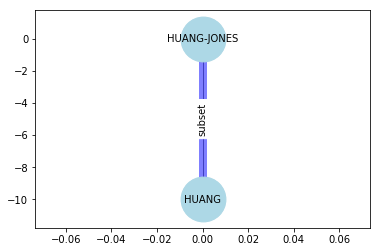

In [43]:
nm.plot_persons('J', 'HUANG') # only works with names, not the complete network

## Unsupervised graph clustering

(Source code:)[https://github.com/ameyahate/Disambiguation]

**what is the basis for this method. what paper is used to build this model???**

In [17]:
%run disambiguate.py

## network based disambiguation